# AutoRegressive Integrated Moving Average (ARIMA) Model Forecasting

In [109]:
import numpy as np
import pandas as pd
import pmdarima as pm
import matplotlib
# matplotlib.use('nbagg') : matplotlib uses this protocall which makes plots more user intractive like zoom in and zoom out
matplotlib.use('nbagg')
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams  
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
sns.set()

In [19]:
# Load clean
raw_pd = pd.read_csv('../data/interim/trips_per_hour_dropped_na_and_all_outliers_under_001_and_over_999.csv')
raw_pd.request_date = pd.to_datetime(raw_pd.request_date)
ts = raw_pd.set_index(raw_pd.request_date)['trip_counts']
ts_df = pd.DataFrame(ts)

<IPython.core.display.Javascript object>


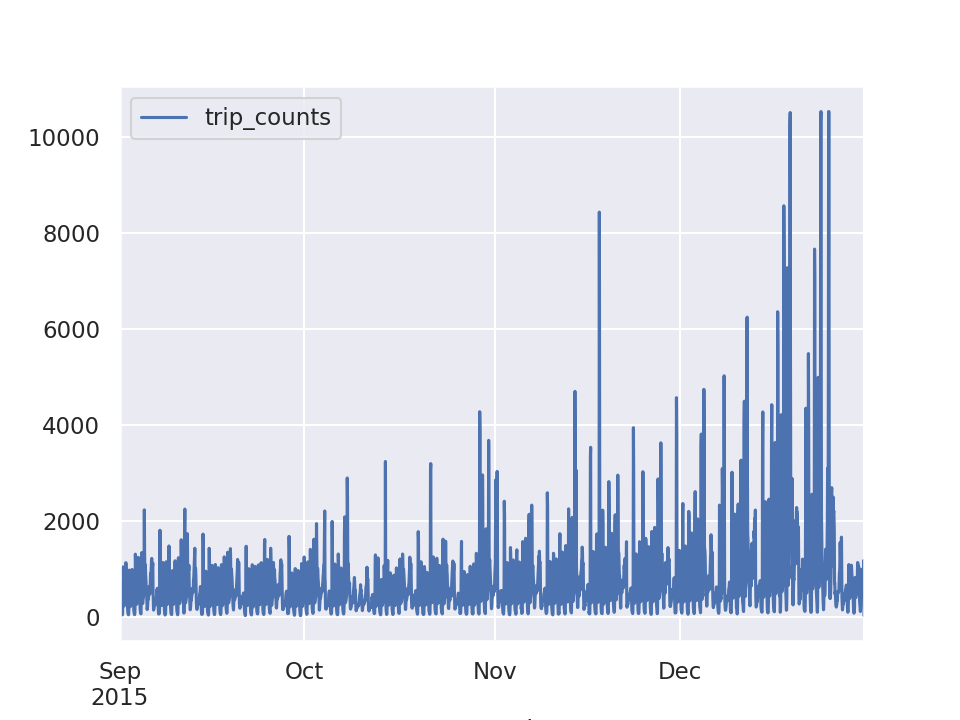

In [20]:
ts_df.plot()
plt.show()

## Test the stationarity of the timeseries

We conduct the ADF, KPSS and PP tests to determine the stationarity of the ts and prepare for ARIMA.

A stationary series is one where the values of the series is not a function of time.

We need to find a way to make the series stationary if we want to model it.

In [26]:
# The following tests, test for different stationarity types.

n_adf = pm.arima.utils.ndiffs(ts, test='adf')
n_kpss = pm.arima.utils.ndiffs(ts, test='kpss')
n_pp = pm.arima.utils.ndiffs(ts, test='pp')

(n_adf, n_kpss, n_pp)
# KPSS is non zero which suggests action should be taken. Later more analytical tests show the same.

(0, 1, 0)

In [33]:
from pmdarima.arima.stationarity import ADFTest

# Test whether we should difference at the alpha=0.05
# significance level
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(ts)  # (0.01, False)

(0.01, False)

In [34]:
from pmdarima.arima.stationarity import KPSSTest

# Test whether we should difference at the alpha=0.05
# significance level
adf_test = KPSSTest(alpha=0.05)
adf_test.should_diff(ts)  # (0.01, False)

(0.01, True)

### Visualize Autocorrelation and Frequencies

The graphs suggest strong autocorrelation, indicationg dependence with previous lags 
and two strong frequencies, a strong sign of seasonality.

<IPython.core.display.Javascript object>


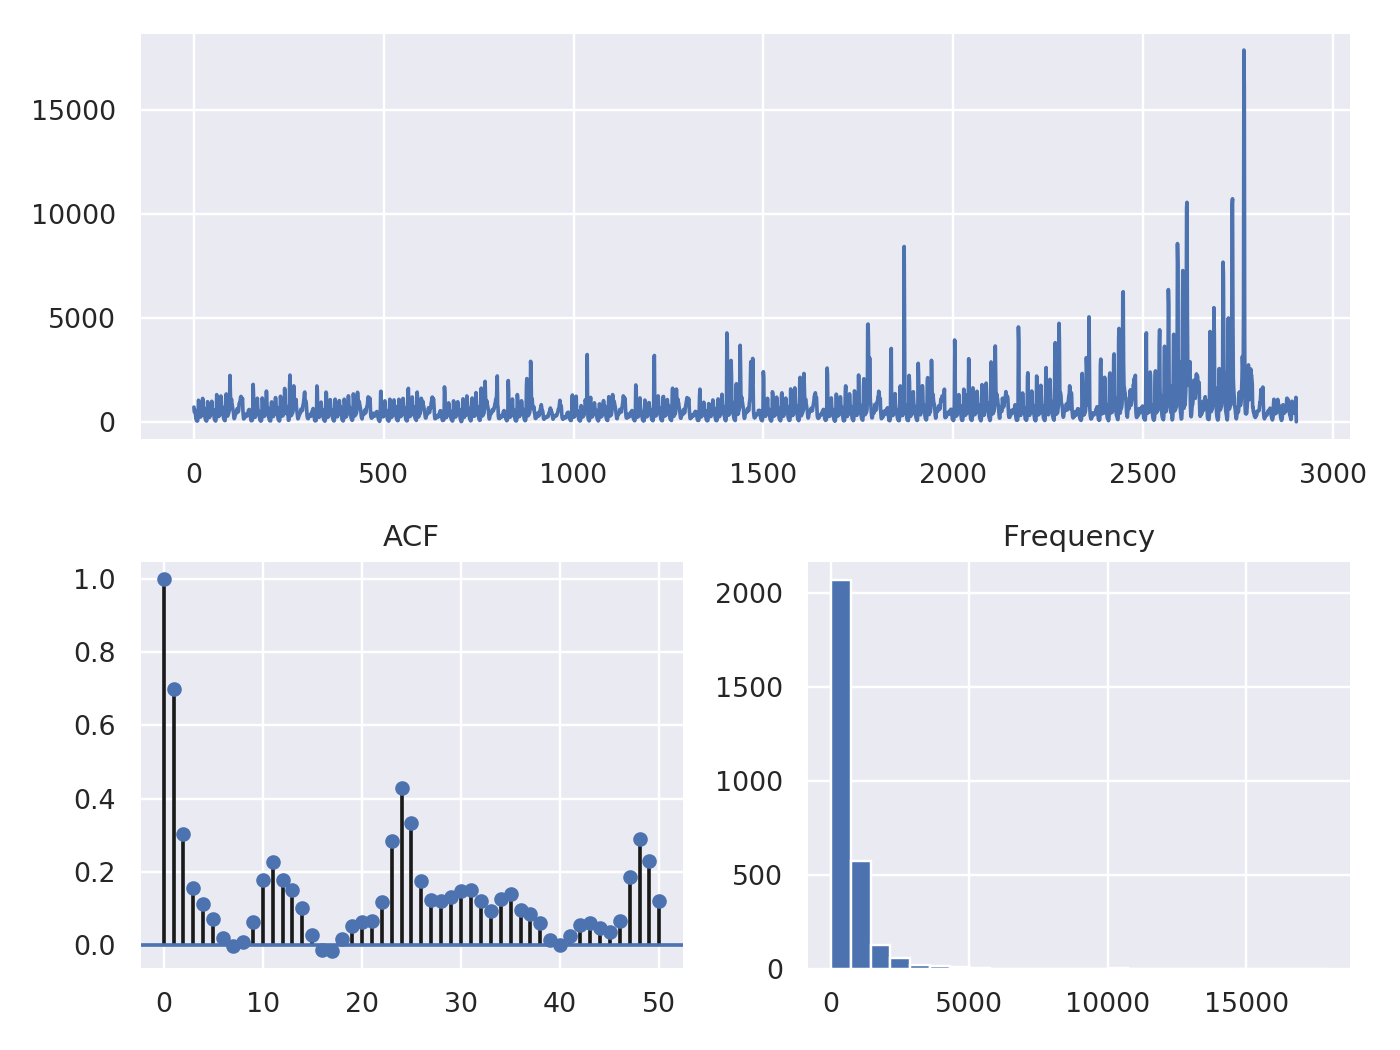

In [36]:
pm.utils.tsdisplay(ts)

### Prepare a simple train-test split

In [32]:
train_len = int(len(ts)*.9)
test_len = len(ts) - train_len
train_len, test_len
from pmdarima.model_selection import train_test_split
y_train, y_test = train_test_split(ts, train_size=train_len)

## Naive Auto ARIMA fitting

Our series has some seasonality in it. Let's start with a model that is completely naive of seasonality.

In [120]:
fit1 = pm.auto_arima(y_train, m=1, trace=True, suppress_warnings=True)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=39816.744, BIC=39851.953, Fit time=5.311 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=40824.938, BIC=40836.674, Fit time=0.054 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=40808.158, BIC=40825.763, Fit time=0.109 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=40748.707, BIC=40766.311, Fit time=0.737 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=40822.939, BIC=40828.807, Fit time=0.075 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=39817.865, BIC=39847.206, Fit time=3.729 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 1); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.994)
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=39950.668, BIC=39980.009, Fit time=2.043 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 1); setting score to inf

In [121]:
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 2614
Model:               SARIMAX(1, 1, 3)   Log Likelihood              -19902.347
Date:                Thu, 16 Jan 2020   AIC                          39816.694
Time:                        00:48:19   BIC                          39851.904
Sample:                             0   HQIC                         39829.448
                               - 2614                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2414      0.190      1.272      0.204      -0.131       0.613
ar.L1          0.1595      0.072      2.224      0.026       0.019       0.300
ma.L1         -0.2362      0.070     -3.361      0.001      -0.374      -0.098
ma.L2         -0.6374      0.015    -42.104      0.000      -0.667      -0.608
ma.L3         -0.1147      0.059     -1.944      0.052      -0.230       0.001
sigma2      2.414e+05   2038.214    118.423      0.000    2.37e+05    2.45e+05
===================================================================================
Ljung-Box (Q):                      922.37   Jarque-Bera (JB):            263126.80
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               8.80   Skew:                             4.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        51.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<IPython.core.display.Javascript object>


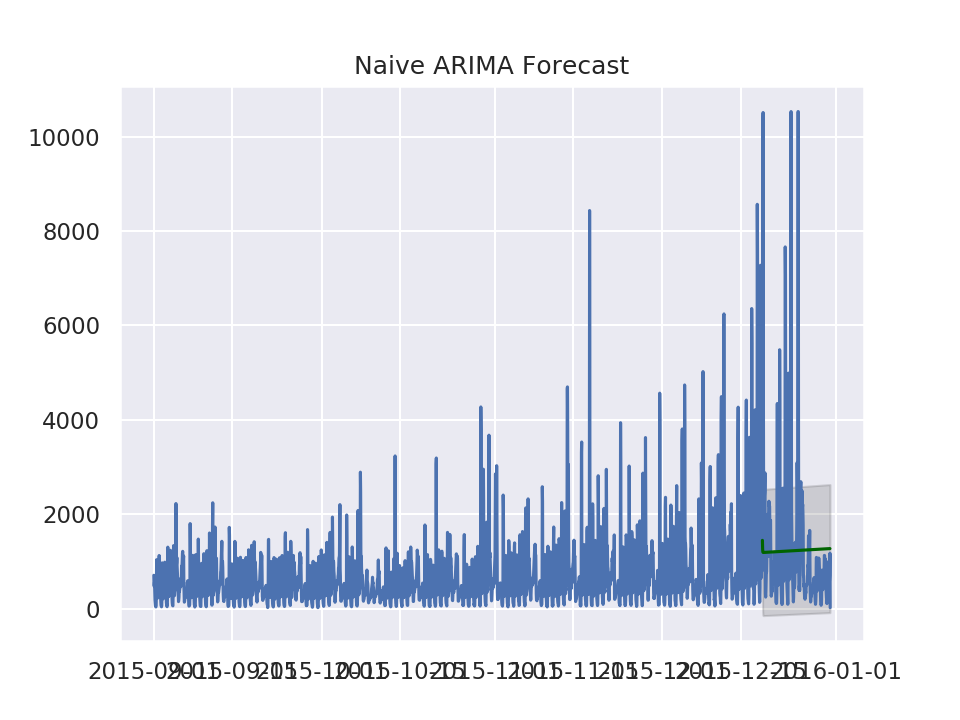

In [122]:
# Forecast
n_periods = test_len
fc, confint = fit1.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(y_train.index[-1], periods = n_periods, freq='1H')

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(ts_df)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Naive ARIMA Forecast")
plt.show()

### Result Intepretation

The previous graph suggests the fit is not very robust. By plotting the model diagnostics below, we see that the standardized residual seems to contain some more information, as it looks like a pattern has remained embedded. The histogram and Q-Q plot do not suggest a normal distribution.

<IPython.core.display.Javascript object>


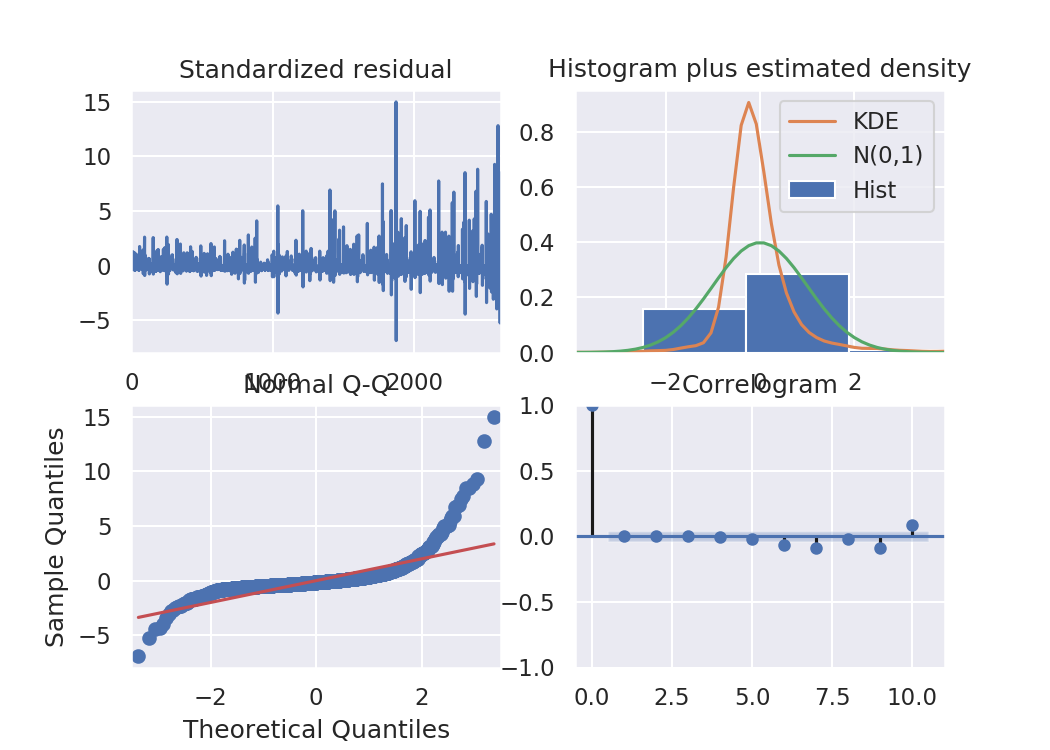

In [123]:
fit1.plot_diagnostics(figsize=(7,5))
plt.show()

In [124]:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(y_test, fc)))


Test RMSE: 1735.529


## Improving the auto ARIMA model: MARIMA

We already know that ARIMA does not cover seasonality and our model has been seen to excibit both hour-of-day and day-of-week seasonality. We may use the parameter m to depict seasonality like so:

- 24 - hour of day
- 7 - day of week
- 12 - monthly
- 52 - week of year

For our case we will need m = 24*7 = 168. This, however, requires infinite computation, so we will stick to just showcasing the day-of-week seasonality with `m=7`.



In [125]:
fit2 = pm.auto_arima(y_train, m=7, trace=True, suppress_warnings=True)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 1, 7); AIC=39793.710, BIC=39840.656, Fit time=17.230 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 7); AIC=40824.938, BIC=40836.674, Fit time=0.079 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 7); AIC=40802.238, BIC=40825.711, Fit time=1.079 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 7); AIC=40747.263, BIC=40770.736, Fit time=1.357 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 7); AIC=40822.939, BIC=40828.807, Fit time=0.065 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 1, 7); AIC=39800.435, BIC=39841.513, Fit time=16.468 seconds
Near non-invertible roots for order (2, 1, 2)(0, 0, 1, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.992)
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 0, 7); AIC=39798.247, BIC=39839.324, Fit time=17.297 seconds
Near non-invertible roots for order (2, 1, 2)(1, 0, 0, 7); setting score to 

In [126]:
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 2614
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 7)   Log Likelihood              -19860.663
Date:                           Thu, 16 Jan 2020   AIC                          39741.326
Time:                                   01:03:07   BIC                          39800.008
Sample:                                        0   HQIC                         39762.582
                                          - 2614                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4785      0.123      3.887      0.000       0.237       0.720
ar.L1          0.3761      0.039      9.717      0.000       0.300       0.452
ar.L2         -0.0636      0.034     -1.866      0.062      -0.130       0.003
ma.L1         -0.4497      0.039    -11.551      0.000      -0.526      -0.373
ma.L2         -0.5500      0.039    -13.938      0.000      -0.627      -0.473
ar.S.L7       -1.3557      0.014    -96.811      0.000      -1.383      -1.328
ar.S.L14      -0.9471      0.013    -70.422      0.000      -0.973      -0.921
ma.S.L7        1.3035      0.012    112.540      0.000       1.281       1.326
ma.S.L14       0.9543      0.010     98.455      0.000       0.935       0.973
sigma2      2.779e+05   3473.684     79.998      0.000    2.71e+05    2.85e+05
===================================================================================
Ljung-Box (Q):                      670.18   Jarque-Bera (JB):            232009.39
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               9.02   Skew:                             4.45
Prob(H) (two-sided):                  0.00   Kurtosis:                        48.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<IPython.core.display.Javascript object>


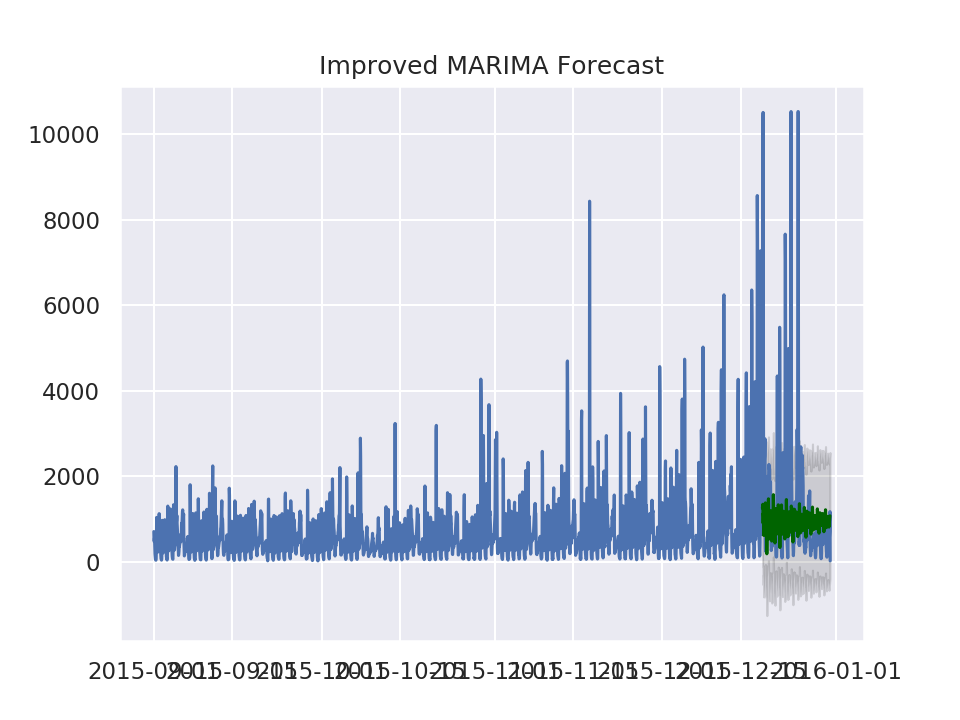

In [128]:
# Forecast
n_periods = test_len
fc, confint = fit2.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(y_train.index[-1], periods = n_periods, freq='1H')

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(ts_df)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Improved MARIMA Forecast")
plt.show()

### Result Intepretation

The previous graph suggests the fit again is not very robust. By plotting the model diagnostics below, we see that the standardized residual seems to contain some more information, as it looks like a pattern has remained embedded. The histogram and Q-Q plot do not suggest a normal distribution.

Still, we can see how the forecast includes a seasonality component, as we wanted. RMSE has not improved much. Neither has AIC.

<IPython.core.display.Javascript object>


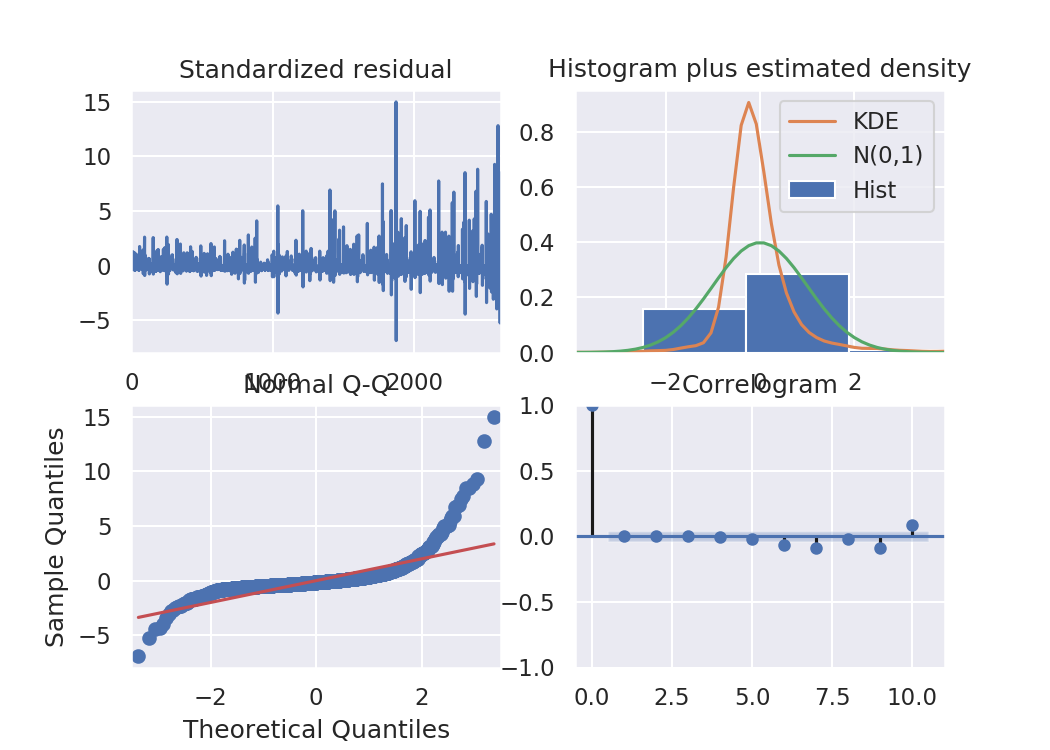

In [129]:
fit1.plot_diagnostics(figsize=(7,5))
plt.show()

In [130]:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(y_test, fc)))


Test RMSE: 1781.449


# Saving progress

In [132]:
import joblib

In [133]:
joblib.dump(fit2, '../models/auto-marima-defaults-m7-resampled-1h-dropedna-droped-outliers-csv')

['../models/auto-marima-defaults-m7-resampled-1h-dropedna-droped-outliers-csv']

In [134]:
joblib_fit2 = joblib.load('../models/auto-marima-defaults-m7-resampled-1h-dropedna-droped-outliers-csv')

# Conclusion

We have examined stationarity and several tests to defined it's type. The ARIMA model was introduced and attempts to model our series with and without simple seasonality components were made.

In the next section, we will examine that the frequency components are very stationary, decompose the timeseries and attempt another prediction, over the trend.